<a href="https://colab.research.google.com/github/Yassinfahmy/Browser-based-Models-with-TensorFlow.js/blob/main/psychRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#clear all variables from previous session
%reset -f 

In [178]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [179]:
import os, sys
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

root_dir = "/content/drive/My Drive/"
project_folder= "Colab Notebooks/Rnn modeling/med noise dataset/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
     os.mkdir(root_dir + project_folder)
     print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/Rnn modeling/med noise dataset/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [180]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
# from data import get_data, format_data
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import shuffle
import pandas as pd
from tensorflow.keras.constraints import MaxNorm 
from keras import backend as K  
from sklearn.decomposition import PCA
try:
  from psychrnn.backend.models.basic import Basic
  from psychrnn.tasks.task import Task
  from psychrnn.backend.initializations import WeightInitializer
except:
 print('Run next 2 cells to install and import psychrnn')

In [181]:
pip install psychrnn

In [182]:

from psychrnn.backend.models.basic import Basic
from psychrnn.tasks.task import Task
from psychrnn.backend.initializations import WeightInitializer

In [220]:
def delete_trial(array, trial_number):
    array = np.delete(array, trial_number, 0)
    return array

def remove_nan_trials(x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset,acquire_time,test_array):
    trials_to_delete = np.where(np.isnan(test_array))#==True)
    trials_to_delete=np.unique(trials_to_delete[0])

    x_trajectory = delete_trial(x_trajectory, trials_to_delete)
    y_trajectory = delete_trial(y_trajectory, trials_to_delete)
    go_cue = delete_trial(go_cue, trials_to_delete)
    x_target = delete_trial(x_target, trials_to_delete)
    y_target = delete_trial(y_target, trials_to_delete)
    flash_1 = delete_trial(flash_1, trials_to_delete)
    offset = delete_trial(offset, trials_to_delete)
    acquire_time = delete_trial(acquire_time, trials_to_delete)
    
    return x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time


def get_data():
    x_trajectory = np.genfromtxt('xTraj.csv', delimiter=',')
    y_trajectory = np.genfromtxt('yTraj.csv', delimiter=',')
    go_cue = np.array(pd.read_table('goCue.csv', delimiter=',', header=None, skip_blank_lines=False))
    x_target = np.genfromtxt('xTarget.csv', delimiter=',')
    y_target = np.genfromtxt('yTarget.csv', delimiter=',')
    flash_1 =np.array(pd.read_table('flash1.csv', delimiter=',', header=None, skip_blank_lines=False))
    acquire_time = np.array(pd.read_table('acquireTime.csv', delimiter=',', header=None, skip_blank_lines=False))
    offset = np.array(pd.read_table('offset.csv', delimiter=',', header=None, skip_blank_lines=False))

    print ('number of trials before removing Nan trials is', x_target.shape[0])

    x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time = remove_nan_trials(x_trajectory, 
    y_trajectory, go_cue, x_target, y_target, flash_1, offset,acquire_time, test_array=acquire_time)

    x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time = remove_nan_trials(x_trajectory, 
    y_trajectory, go_cue, x_target, y_target, flash_1, offset,acquire_time, test_array=go_cue)

    x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time = remove_nan_trials(x_trajectory, 
    y_trajectory, go_cue, x_target, y_target, flash_1, offset,acquire_time, test_array=flash_1)

    print ('number of trials after removing Nan trials is', x_target.shape[0])

    return x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time


def post_padding(traj,seq_len):
    for row in range(len(traj)):
        while len(traj[row]) < seq_len:
            traj[row].append(traj[row][len(traj[row]) - 1])
    return traj


def format_trajectory(trajectory, flash1, end_time,seq_len,go_signal):
    traj = []
    time_zero = flash1 - 200
    for row in range(trajectory.shape[0]):
        traj.append([])
        for column in range(trajectory.shape[1]):
            if column >= time_zero[row] and column <= end_time[row]:
                traj[row].append(trajectory[row, column])
    traj= np.array(post_padding(traj,seq_len))

    for trial in range(traj.shape[0]):
      for timestep in range(traj.shape[1]):
        if go_signal[trial,timestep]==0:
          c=timestep-0
          break
      traj[trial,:c]=0

    return traj


def format_target(target,extension):
  an_array = np.empty((target.shape[0],extension))   
  an_array[:] = np.NaN
  target= np.concatenate((target,an_array), axis=1)
  for row in range(target.shape[0]):
      for column in range(target.shape[1]):
          if np.isnan(target[row, column]):
              k = target[row, column - 1]
              break
      nan_values = np.where(np.isnan(target[row]))
      target[row, nan_values] = k
  diff=int((2520-target.shape[1])+100)
  target_off = np.zeros((target.shape[0],diff))
  target= np.concatenate((target,target_off),axis=1)
  return target

def format_go_cue(go_cue, flash_1,num_of_trials,seq_len):
    go_signal = np.ones((num_of_trials, seq_len))
    # we are taking 200 ms before the first flash as our start of trial time
    time_zero = flash_1 - 200
    #delta will be the time from the start of the trial to the go cue release
    delta = go_cue - time_zero
    #we iterate over each trial and each timestep to find the time delta for each trial and set the gocue to zero from that point on (1 is hold, 0 is go)
    for trial in range(go_signal.shape[0]):
        for time_step in range(go_signal.shape[1]):
            if (time_step >= delta[trial]).any():
                go_signal[trial, time_step] = 0
    return go_signal

def scale(two_d_array,scale=1):
    num_trials, seq_len = two_d_array.shape
    two_d_array = np.reshape(two_d_array, newshape=(-1,1))
    # scaler = MinMaxScaler(feature_range=(-1,1), copy=False)
    # two_d_array = scaler.fit_transform(two_d_array)
    two_d_array=normalize(two_d_array,axis=0,norm='max')
    two_d_array = np.reshape(two_d_array, newshape=( num_trials, seq_len))
    # v=(np.absolute(np.max(two_d_array)),np.absolute(np.min(two_d_array)))
    # v= np.max(v)
    # two_d_array = two_d_array*scale/v
    return two_d_array

def format_input(x_target, y_target, go_signal, offset,for_testing):
    trials = np.where(offset == 0)
    x_target = x_target[trials[0], :]
    y_target = y_target[trials[0], :]
    go_signal = go_signal[trials[0], :]
    x_target = scale(x_target)
    y_target = scale(y_target)
    if for_testing==False:
      x_target = np.reshape(x_target, (x_target.shape[0], 1, -1))
      y_target = np.reshape(y_target, (y_target.shape[0], 1, -1))
      go_signal = np.reshape(go_signal, (go_signal.shape[0], 1, -1))
      input = np.concatenate([x_target, y_target], axis=1)
      input = np.concatenate([input,go_signal], axis=1)
    elif for_testing==True:
      x_target = np.reshape(x_target, (x_target.shape[0], -1, 1))
      y_target = np.reshape(y_target, (y_target.shape[0], -1, 1))
      go_signal = np.reshape(go_signal, (go_signal.shape[0], -1, 1))
      input = np.concatenate([x_target, y_target], axis=-1)
      input = np.concatenate([input,go_signal], axis=-1)
    return input

def format_pert_trials_input(x_target, y_target, go_signal, offset,for_testing):
    trials = np.where(offset != 0)
    x_target = x_target[trials[0], :]
    y_target = y_target[trials[0], :]
    go_signal = go_signal[trials[0], :]
    x_target = scale(x_target)
    y_target = scale(y_target)
    if for_testing==False:
      x_target = np.reshape(x_target, (x_target.shape[0], 1, -1))
      y_target = np.reshape(y_target, (y_target.shape[0], 1, -1))
      go_signal = np.reshape(go_signal, (go_signal.shape[0], 1, -1))
      input = np.concatenate([x_target, y_target], axis=1)
      input = np.concatenate([input,go_signal], axis=1)
    elif for_testing==True:
      x_target = np.reshape(x_target, (x_target.shape[0], -1, 1))
      y_target = np.reshape(y_target, (y_target.shape[0], -1, 1))
      go_signal = np.reshape(go_signal, (go_signal.shape[0], -1, 1))
      input = np.concatenate([x_target, y_target], axis=-1)
      input = np.concatenate([input,go_signal], axis=-1)
    return input


def format_output(x_traj, y_traj, x_velocity, y_velocity, offset,for_testing):
    trials = np.where(offset == 0)
    pert_trials = np.where(offset != 0)  # to be used later
    x_traj = x_traj[trials[0], :]
    y_traj = y_traj[trials[0], :]
    x_velocity = x_velocity[trials[0], :]
    y_velocity = y_velocity[trials[0], :]
    x_traj = scale(x_traj)
    y_traj= scale(y_traj)
    x_velocity = scale(x_velocity)
    y_velocity = scale(y_velocity)
    if for_testing==False:
      x_traj = np.reshape(x_traj, (x_traj.shape[0], 1, -1))
      y_traj = np.reshape(y_traj, (y_traj.shape[0], 1, -1))
      x_velocity = np.reshape(x_velocity, (x_velocity.shape[0], 1, -1))
      y_velocity = np.reshape(y_velocity, (y_velocity.shape[0], 1, -1))
      output = np.concatenate([x_traj, y_traj], axis=1)
      output = np.concatenate([output, x_velocity, y_velocity], axis=1)
    elif for_testing==True:
      x_traj = np.reshape(x_traj, (x_traj.shape[0], -1, 1))
      y_traj = np.reshape(y_traj, (y_traj.shape[0], -1, 1))
      x_velocity = np.reshape(x_velocity, (x_velocity.shape[0], -1, 1))
      y_velocity = np.reshape(y_velocity, (y_velocity.shape[0], -1, 1))
      output = np.concatenate([x_traj, y_traj], axis=-1)
      output = np.concatenate([output, x_velocity, y_velocity], axis=-1)
    return output

def format_pert_trials_output(x_traj, y_traj, x_velocity, y_velocity, offset,for_testing):
    trials = np.where(offset != 0)  # to be used later
    x_traj = x_traj[trials[0], :]
    y_traj = y_traj[trials[0], :]
    x_velocity = x_velocity[trials[0], :]
    y_velocity = y_velocity[trials[0], :]
    x_traj = scale(x_traj)
    y_traj= scale(y_traj)
    x_velocity = scale(x_velocity)
    y_velocity = scale(y_velocity)
    if for_testing==False:
      x_traj = np.reshape(x_traj, (x_traj.shape[0], 1, -1))
      y_traj = np.reshape(y_traj, (y_traj.shape[0], 1, -1))
      x_velocity = np.reshape(x_velocity, (x_velocity.shape[0], 1, -1))
      y_velocity = np.reshape(y_velocity, (y_velocity.shape[0], 1, -1))
      output = np.concatenate([x_traj, y_traj], axis=1)
      output = np.concatenate([output, x_velocity, y_velocity], axis=1)
    elif for_testing==True:
      x_traj = np.reshape(x_traj, (x_traj.shape[0], -1, 1))
      y_traj = np.reshape(y_traj, (y_traj.shape[0], -1, 1))
      x_velocity = np.reshape(x_velocity, (x_velocity.shape[0], -1, 1))
      y_velocity = np.reshape(y_velocity, (y_velocity.shape[0], -1, 1))
      output = np.concatenate([x_traj, y_traj], axis=-1)
      output = np.concatenate([output, x_velocity, y_velocity], axis=-1)
    return output

def butter_lowpass_filter(data, order=2):
    # Get the filter coefficients
    b, a = butter(order, 0.05, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def calculate_velocities(traj,dt):
    dt=1
    vel = []
    for row in range(traj.shape[0]):
        vel.append([])
        for column in range(traj.shape[1]):
            if column == traj.shape[1] - 1:
                vel[row].append(0)
            else:
                vel[row].append((traj[row, column + 1] - traj[row, column])/dt)
    vel=np.array(vel)
    vel = butter_lowpass_filter(vel)

    return vel 


def plot_trials(input, output, num):
    # num = np.random.choice(input.shape[0], num)
    # for trial in range(num.shape[0]):
  fig, axs = plt.subplots(2, 2)
  axs[0, 0].plot(input[num, :, 0], label='x target')
  axs[0, 0].plot(input[num, :, 2], label='go signal')
  axs[0, 0].plot(output[num, :, 0], label='x trajectory')
  axs[1, 0].plot(output[num, :, 2], label='x velocity')
  axs[0, 0].legend()
  axs[1, 0].legend()
  axs[0, 1].plot(input[num, :, 1], label='y target')
  axs[0, 1].plot(input[num, :, 2], label='go signal')
  axs[0, 1].plot(output[num, :, 1], label='y trajectory')
  axs[1, 1].plot(output[num, :, 3], label='y velocity')
  axs[0, 1].legend()
  axs[1, 1].legend()
  fig.suptitle(('Trial number ' + str(num)))
  fig.show()
  plt.show()

def down_sample(array,dt=1):
    array= array[:,::dt]
    return array

def add_output_catch_trials(output):
    num_trials, seq_len, num_features = output.shape
    catch_output= np.zeros((int(np.round(num_trials*0.1,0)),seq_len,num_features))
    output= np.concatenate((output,catch_output),axis=0)
    return output

def add_input_catch_trials(input):
    num_trials, seq_len, num_features = input.shape
    catch_input_no_go= np.zeros((int(np.round(num_trials*0.05,0)),seq_len,num_features))
    catch_input_no_go[:,:,(0,1)]=input[:catch_input_no_go.shape[0],:,(0,1)]

    catch_input_no_target= np.zeros((int(np.round(num_trials*0.05,0)),seq_len,num_features))
    catch_input_no_target[:,:,2]=input[:catch_input_no_target.shape[0],:,2]

    input= np.concatenate((input,catch_input_no_go,catch_input_no_target),axis=0)
    return input

def remove_no_go_trials(x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time):
    trials_to_delete = np.where(go_signal[:,-200]==1)
    x_traj = delete_trial(x_traj, trials_to_delete)
    y_traj = delete_trial(y_traj, trials_to_delete)
    go_signal = delete_trial(go_signal, trials_to_delete)
    x_target = delete_trial(x_target, trials_to_delete)
    y_target = delete_trial(y_target, trials_to_delete)
    flash_1 = delete_trial(flash_1, trials_to_delete)
    offset = delete_trial(offset, trials_to_delete)
    acquire_time = delete_trial(acquire_time, trials_to_delete)
    return x_traj, y_traj, go_signal,x_target, y_target, flash_1, offset, acquire_time

      
def format_data(x_target, y_target, x_trajectory, y_trajectory, go_cue, flash_1, acquire_time, offset,tau=50,dt=1,for_testing=False, return_var=False):
    extension=0
    acquire_time = acquire_time+ extension
    x_target = format_target(x_target, extension)
    y_target = format_target(y_target, extension)
    num_of_trials = x_target.shape[0]
    seq_len = x_target.shape[1]
    go_signal = format_go_cue(go_cue, flash_1, num_of_trials, seq_len)
    x_traj = format_trajectory(x_trajectory, flash_1, acquire_time,seq_len,go_signal)
    y_traj = format_trajectory(y_trajectory, flash_1, acquire_time,seq_len,go_signal)

# getting rid of empty, no go cue trials
    x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time = remove_nan_trials(x_traj, y_traj, go_signal,
    x_target, y_target, flash_1, offset, acquire_time, test_array=x_traj)
    x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time = remove_nan_trials(x_traj, y_traj, go_signal,
    x_target, y_target, flash_1, offset, acquire_time, test_array=y_traj)
    x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time = remove_no_go_trials(x_traj, y_traj, go_signal,
    x_target, y_target, flash_1, offset, acquire_time)

    if return_var:
      return x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time

    x_velocity = calculate_velocities(x_traj,dt)
    y_velocity = calculate_velocities(y_traj,dt)

    if for_testing==True:
      x_target = down_sample(x_target,dt)
      y_target = down_sample(y_target,dt)
      go_signal = down_sample(go_signal,dt)
      x_traj = down_sample(x_traj,dt)
      y_traj = down_sample(y_traj,dt)
      x_velocity = down_sample(x_velocity,dt)
      y_velocity = down_sample(y_velocity,dt)

    if np.array(np.where(offset==0)).size !=0:
      input = format_input(x_target, y_target, go_signal, offset,for_testing)
      output = format_output(x_traj, y_traj, x_velocity, y_velocity, offset,for_testing)
    else:
      input=np.array([0])
      output=np.array([0])
      print('no non-pert trials found')

    pert_input= format_pert_trials_input(x_target, y_target, go_signal, offset,for_testing)
    pert_output = format_pert_trials_output(x_traj, y_traj, x_velocity, y_velocity, offset,for_testing)

    # output= add_output_catch_trials(output)
    # input = add_input_catch_trials(input)

    print(input.shape[0],' non-pertubation trials')
    print(pert_input.shape[0],'pertubation trials')
    return input, output, pert_input, pert_output

def performance_measure(trial_batch, trial_y, output_mask, output, epoch, losses, verbosity):
  r2=dr.coeff_determination(trial_y, output, output_mask)
  return r2
  
def plot_metric(loss, metric,start=-1,end=0):
  if start==-1 and end==0:
    L = history.history[loss]
    val_L = history.history['val_' + loss]
    m = history.history[metric]
    val_m = history.history['val_' + metric]
  else:
    L = history.history[loss]
    L = L[start:end]
    val_L = history.history['val_' + loss]
    val_L = val_L[start:end]
    m = history.history[metric]
    m = m[start:end]
    val_m = history.history['val_' + metric]
    val_m = val_m[start:end]
    
  epochs = range(len(L))
  fig,axs = plt.subplots(2,figsize=(20,10))
  axs[0].plot(epochs, L, label=str(loss))
  axs[0].plot(epochs, val_L, label='Validation ' + str(loss))
  axs[1].plot(epochs, m , label= str(metric))
  axs[1].plot(epochs, val_m , label='Validation ' + str(metric))
  axs[0].legend()
  axs[1].legend()
  plt.show()

def plot_results(input,output,y_hat,num,save=False):
    num = np.random.choice(y_hat.shape[0], num)
    for trial in range(num.shape[0]):
        fig, axs = plt.subplots(2, 2,figsize=(20,10))
        axs[0, 0].plot(output[num[trial], :, 0], label='x trajectory',c='b')
        axs[0, 0].plot(y_hat[num[trial], :, 0], label='Sim x trajectory',c='g')
        axs[0, 0].plot(input[num[trial], :, 2], label='go signal',c='r')
        axs[0, 0].plot(input[num[trial], :, 0], label='x target',c='k')
        axs[1, 0].plot(output[num[trial], :, 2], label='x velocity',c='b')
        axs[1, 0].plot(y_hat[num[trial], :, 2], label='Sim x velocity',c='g')
        axs[1,0].axis([0,y_hat.shape[1],-1,1])
        axs[0, 0].legend()
        axs[1, 0].legend()
        axs[0, 1].plot(output[num[trial], :, 1], label='y trajectory',c='b')
        axs[0, 1].plot(y_hat[num[trial], :, 1], label='Sim y trajectory',c='g')
        axs[0, 1].plot(input[num[trial], :, 1], label='y target',c='k')
        axs[0, 1].plot(input[num[trial], :, 2], label='go signal',c='r')
        axs[1, 1].plot(output[num[trial], :, 3], label='y velocity',c='b')
        axs[1, 1].plot(y_hat[num[trial], :, 3], label='Sim y velocity',c='g')
        axs[1,1].axis([0,y_hat.shape[1],-1,1])
        axs[0, 1].legend()
        axs[1, 1].legend()
        fig.suptitle(('Trial number ' + str(num[trial])))
        fig.show()
        if save==True:
          plt.savefig(str(num[trial])+'RNN trials.png')
    plt.show()

def get_target_locations(data_in,loc=-15):
    locations= np.zeros((data_in.shape[0],2))
    for i in range(data_in.shape[0]):
      locations[i,0]= data_in[i,loc,0]
      locations[i,1]= data_in[i,loc,1]
    locations= np.unique(locations, axis=0)
    return locations

def plot_firing_rates_accross_conditions(firing_rates,save=False):
    loc=-15
    for neuron in range(100):
      for i in range(firing_rates.shape[0]):
        plt.plot(firing_rates[i,:,neuron])
      plt.title('Neuron number' + str(neuron+1))
      if save==True:
        plt.savefig(str(neuron+1)+'RNN firing rates.png')
      plt.show()

def get_avg_firing_rates(pert_data_in,firing_rates):
    go_cue_time=121
    loc = get_target_locations(pert_data_in,go_cue_time)
    loc1=[]
    loc2=[]
    loc3=[]
    loc4=[]
    loc5=[]
    loc6=[]
    loc7=[]
    loc8=[]
    for i in range(firing_rates.shape[0]):
      if pert_data_in[i,go_cue_time,0]==loc[0,0] and pert_data_in[i,go_cue_time,1]==loc[0,1]:
        loc1.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[1,0] and pert_data_in[i,go_cue_time,1]==loc[1,1]:
        loc2.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[2,0] and pert_data_in[i,go_cue_time,1]==loc[2,1]:
        loc3.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[3,0] and pert_data_in[i,go_cue_time,1]==loc[3,1]:
        loc4.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[4,0] and pert_data_in[i,go_cue_time,1]==loc[4,1]:
        loc5.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[5,0] and pert_data_in[i,go_cue_time,1]==loc[5,1]:
        loc6.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[6,0] and pert_data_in[i,go_cue_time,1]==loc[6,1]:
        loc7.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[7,0] and pert_data_in[i,go_cue_time,1]==loc[7,1]:
        loc8.append(i)
    fr=np.ones((8,firing_rates.shape[1],firing_rates.shape[2]))
    fr[0,:]=np.average(firing_rates[loc1,:,:],axis=0)
    fr[1,:]=np.average(firing_rates[loc2,:,:],axis=0)
    fr[2,:]=np.average(firing_rates[loc3,:,:],axis=0)
    fr[3,:]=np.average(firing_rates[loc4,:,:],axis=0)
    fr[4,:]=np.average(firing_rates[loc5,:,:],axis=0)
    fr[5,:]=np.average(firing_rates[loc6,:,:],axis=0)
    fr[6,:]=np.average(firing_rates[loc7,:,:],axis=0)
    fr[7,:]=np.average(firing_rates[loc8,:,:],axis=0)
    return fr

def prep_data_for_pca(fr,go_cue_time=121):
    num_cond=fr.shape[0]
    avg=[]
    i=0
    for neuron in range(fr.shape[2]):
      avg.append([])
      for time_step in range(fr.shape[1]):
        for condition in range(fr.shape[0]):
          i+=fr[condition,time_step,neuron]
        avg[neuron].append(i/num_cond)
        i=0
    avg=np.array(avg)
    mod_fr=np.ones((fr.shape[0],fr.shape[1],fr.shape[2]))
    for neuron in range(fr.shape[2]):
      for condition in range(fr.shape[0]):
        mod_fr[condition,:,neuron]=(fr[condition,:,neuron]-avg[neuron])

    pca_fr=np.ones((1,mod_fr.shape[2]))
    for array in mod_fr:
      pca_fr= np.concatenate((pca_fr,array),axis=0)
    pca_fr=pca_fr[1:,:]

    return pca_fr

def plot_trials_in_2d(pert_data_in,pert_data_out,y_hat,num_of_trials=10,show_single_trials=False):
    
    plt.figure(figsize=(10,10))
    for i in range(num_of_trials):
      plt.scatter(pert_data_in[i,:,0],pert_data_in[i,:,1],c='r')
      for time_step in range(pert_data_in.shape[0]):
        if pert_data_in[i,time_step,2]==0:
          break
      plt.plot(pert_data_out[i,:time_step,0],pert_data_out[i,:time_step,1],c='K')
      plt.plot(pert_data_out[i,time_step:,0],pert_data_out[i,time_step:,1],c='b')
      plt.plot(y_hat[i,:time_step,0],y_hat[i,:time_step,1],c='k')
      plt.plot(y_hat[i,time_step:,0],y_hat[i,time_step:,1],c='g')
      plt.axis([-1,1,-1,1])
      if show_single_trials==True:
        plt.show()

def construct_test_trials(delay,offset_degree,go_cue_time=1210, t_onset=210):
    t_onset=int(t_onset/dt)
    target_off_time=(T/dt)-10
    go_cue_time=int(go_cue_time/dt)
    t_switch= go_cue_time-(delay/dt)
    x=np.zeros((8,int(np.round(T/dt,0)),3))
    t_loc=np.array([[ 1.        ,  0.        ],
                    [ 0.70710678,  0.70710678],
                    [ 0.        ,  1.        ],
                    [-0.70710678,  0.70710678],
                    [-1.        ,  0.        ],
                    [-0.70710678, -0.70710678],
                    [ 0.        , -1.        ],
                    [ 0.70710678, -0.70710678]])
    offsets=np.reshape((np.arange(45,360,45)),(-1,1))
    v=np.reshape((np.arange(1,8,1)),(-1,1))
    offsets = np.concatenate((offsets,v),axis=1)
    for i in range(N_batch+8):
      if i*8>=N_batch:
        j=i
        break
    for i in offsets:
      if i[0]==offset_degree:
        p=i[1]
    for trial in range(8):
      for time in range(x.shape[1]):
        if time>=t_onset and time<t_switch:
          x[trial,time,0]=t_loc[trial,0]
          x[trial,time,1]=t_loc[trial,1]
        if time>=t_switch and time<target_off_time:
          x[trial,time,0]=t_loc[trial-p,0]
          x[trial,time,1]=t_loc[trial-p,1]
        if time<go_cue_time:
          x[trial,time,2]= 1
        if time>=go_cue_time:
          x[trial,time,2]= 0
    x= np.repeat(x,j,0)
    x=x[:N_batch,:,:]
    #split test trial into pretarget and target
    for trial in range(x.shape[0]):
      for time_stamp in range(35,75):
        x[trial,time_stamp,0]=0
        x[trial,time_stamp,1]=0
    return x

def predict(model, data_in, N_batch=76,N_rec=100):
    num_trials= int(data_in.shape[0]/N_batch)*N_batch
    non_pert_y_hat = np.ones((num_trials,data_in.shape[1],4))
    non_pert_firing_rates =np.ones((num_trials,data_in.shape[1],N_rec))
    j=0
    for i in np.arange(N_batch,num_trials+N_batch,N_batch):#data_in.shape[0]+N_batch
      x = data_in[j:i,:,:]
      y_pred, state = Model.test(x)
      non_pert_y_hat[j:i,:,:] = y_pred
      non_pert_firing_rates[j:i,:,:] = state
      j=i
    return non_pert_y_hat, non_pert_firing_rates

def run_and_construct_test_trials_of_var_delays(time_increment,offset_angle,delay_range,go_cue_time=1210):
    #construct and test a bunch of trials with different delays
    test_trials=[]
    test_output=[]
    test_fr=[]
    delays=[]
    for i in range (delay_range[0],delay_range[1]+time_increment,time_increment):
      test_trials.append(construct_test_trials(i,offset_angle,go_cue_time,210))
      y,fr=basicModel.test(test_trials[int((i-delay_range[0])/time_increment)])
      test_output.append(y)
      test_fr.append(fr)
      delays.append(i)
    test_output = np.array(test_output)
    test_fr = np.array(test_fr)
    test_trials = np.array(test_trials)
    return test_output, test_trials, test_fr, delays

def plot_trials_w_var_delays(test_output, test_trials, delays):
    test_output, ind = np.unique(test_output,axis=1,return_index=True)
    test_output = test_output[:,np.argsort(ind)]
    test_trials, ind = np.unique(test_trials,axis=1,return_index=True)
    test_trials = test_trials[:,np.argsort(ind)]
    #plot trials output with different delays of the same offset
    for i in range(test_output.shape[1]):
      plt.figure(figsize=(10,10))
      for j in range(test_output.shape[0]):
        plt.plot(test_output[j,i,119:,0], test_output[j,i,119:,1],label=(str(delays[j])+'ms delay'))
        plt.scatter(test_trials[j,i,:,0],test_trials[j,i,:,1],c='k')
        plt.axis([-1,1,-1,1])
        plt.legend()
      plt.show()

def perform_pca(model, test_fr,test_trials,limit):
    pca_test_fr=[]
    limit=int(limit/dt)
    for i in range(test_fr.shape[0]):
      z=get_avg_firing_rates(test_trials[i],test_fr[i])
      pca_test_fr.append(prep_data_for_pca(z[:,:limit,:]))
    pca_test_fr= np.array(pca_test_fr)
    non_pert_y_hat, non_pert_firing_rates = predict(model, od.input,N_batch, N_rec)
    non_pert_firing_rates = get_avg_firing_rates(od.input,non_pert_firing_rates)
    pca_ready_fr=prep_data_for_pca(non_pert_firing_rates[:,:limit,:])
    pca = PCA(3)
    non_pert_pca_fr=pca.fit_transform(pca_ready_fr)
    transformed_test_fr=[]
    for i in range(pca_test_fr.shape[0]):
      transformed_test_fr.append(pca.transform(pca_test_fr[i]))
    transformed_test_fr=np.array(transformed_test_fr)
    return transformed_test_fr, non_pert_pca_fr

def plot_first_2pcs(transformed_test_fr, non_pert_pca_fr, delays, limit, go_cue_time=1210):
    limit=int(limit/dt)
    plt.figure(figsize=(20,10))
    j=0
    for i in range(limit,non_pert_pca_fr.shape[0]+limit,limit):
      plt.plot(non_pert_pca_fr[j:i,0],non_pert_pca_fr[j:i,1],c='b',marker='s',alpha=0.05)
      for n in range(transformed_test_fr.shape[0]):
        if i==limit:
          plt.plot(transformed_test_fr[n,j:i,0],transformed_test_fr[n,j:i,1],label=(str(delays[n])+ 'ms delay')) #,c=c[n]
        else:
          plt.plot(transformed_test_fr[n,j:i,0],transformed_test_fr[n,j:i,1])

        #plot target-switch loc
        # loc= int(j+((go_cue_time/dt)-((delays[n]+1)/dt)))
        # plt.scatter(transformed_test_fr[n,loc,0],transformed_test_fr[n,loc,1],marker='o',color='k')
        loc=j+80
        plt.scatter(transformed_test_fr[n,loc,0],transformed_test_fr[n,loc,1],marker='o',color='k')
      j=i
      plt.legend()

class dataset():
    def __init__(self,loc):
      self.project_folder= "Colab Notebooks/Rnn modeling/"
      self.loc=loc
      self.project_folder=os.path.join(self.project_folder,loc)
      create_and_set_working_directory(self.project_folder)
      self.x_trajectory, self.y_trajectory, self.go_cue, self.x_target, self.y_target, self.flash_1, self.offset, self.acquire_time = get_data() 
      self.input, self.output, self.pert_input, self.pert_output = format_data(self.x_target, self.y_target, self.x_trajectory, self.y_trajectory, self.go_cue, self.flash_1, self.acquire_time, self.offset,dt=10,for_testing=True)
      #go back to initial working directory
      create_and_set_working_directory(project_folder)

    def save_pcs(self):
      limit=int(1200/dt)
      pca_ready_fr=prep_data_for_pca(self.avg_non_pert_firing_rates[:,:limit,:])
      self.pca = PCA(3)
      self.pc_fr=self.pca.fit_transform(pca_ready_fr)

    def split_input(self):
      if self.input.shape[0]>2:
        for trial in range(self.input.shape[0]):
          for time_stamp in range(35,81):
            self.input[trial,time_stamp,0]=0
            self.input[trial,time_stamp,1]=0
      if self.pert_input.shape[0]>2:
        for trial in range(self.pert_input.shape[0]):
          for time_stamp in range(35,81):
            self.pert_input[trial,time_stamp,0]=0
            self.pert_input[trial,time_stamp,1]=0
      

    def recover_data(self):
      self.x_trajectory, self.y_trajectory, self.go_cue, self.x_target, self.y_target, self.flash_1, self.offset, self.acquire_time = format_data(self.x_target, self.y_target, self.x_trajectory, self.y_trajectory, self.go_cue, self.flash_1, self.acquire_time, self.offset,dt=10,for_testing=True,return_var=True)

    def run_non_pert_trials(self, model):
      self.non_pert_y_hat, self.non_pert_firing_rates = predict(model, self.input,N_batch, N_rec)
      self.avg_non_pert_firing_rates = get_avg_firing_rates(self.input,self.non_pert_firing_rates)
      # plot_firing_rates_accross_conditions(self.non_pert_firing_rates,False)
      plot_trials_in_2d(self.input,self.output,self.non_pert_y_hat,760)
      plot_results(self.input,self.output,self.non_pert_y_hat,10,False)
    
    def format_data_to_train_model(self, return_data=False, split_target=False):
      self.x, self.y, self.pert_x, self.pert_y = format_data(self.x_target, self.y_target, self.x_trajectory, self.y_trajectory, self.go_cue, self.flash_1, self.acquire_time, self.offset,dt=10,for_testing=False)
      if split_target:
        if self.x.shape[0]>2:
          for trial in range(self.x.shape[0]):
            for time_stamp in range(350,810):
              self.x[trial,0,time_stamp]=0
              self.x[trial,1,time_stamp]=0
        if self.pert_x.shape[0]>2:
          for trial in range(self.pert_x.shape[0]):
            for time_stamp in range(350,810):
              self.pert_x[trial,0,time_stamp]=0
              self.pert_x[trial,1,time_stamp]=0
      if return_data:
        return self.x, self.y, self.pert_x, self.pert_y
    
    def run_pert_trials(self,model):
      #################for the  pertubation trials in the dataset
      self.y_hat, self.firing_rates = predict(model, self.pert_input,N_batch,N_rec)
      self.fr= get_avg_firing_rates(self.pert_input,self.firing_rates)
      # plot_firing_rates_accross_conditions(fr,False)
      plot_results(self.pert_input,self.pert_output,self.y_hat,10,False)
      plot_trials_in_2d(self.pert_input,self.pert_output,self.y_hat, 5, show_single_trials=True)


In [ ]:
x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time = get_data() 
input, output, pert_input, pert_output = format_data(x_target, y_target, x_trajectory, y_trajectory, go_cue, flash_1, acquire_time, offset,dt=1,for_testing=False)

# #to train on both kinds of trials simultanously
# input=np.concatenate((input,pert_input),axis=0)
# output=np.concatenate((output,pert_output),axis=0)

from sklearn.utils import shuffle
input, output = shuffle(input,output)


In [7]:
hn=dataset('high noise dataset')
hn.format_data_to_train_model()


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/Rnn modeling/high noise dataset

An empty text file was created there. You can also run !pwd to confirm the current working directory.
number of trials before removing Nan trials is 2003
number of trials after removing Nan trials is 1780
no non-pert trials found
1  non-pertubation trials
1779 pertubation trials

Your working directory was changed to /content/drive/My Drive/Colab Notebooks/Rnn modeling/med noise dataset/

An empty text file was created there. You can also run !pwd to confirm the current working directory.
no non-pert trials found
1  non-pertubation trials
1779 pertubation trials


In [19]:
mn=dataset('med noise dataset')
mn.format_data_to_train_model()


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/Rnn modeling/med noise dataset

An empty text file was created there. You can also run !pwd to confirm the current working directory.
number of trials before removing Nan trials is 2002
number of trials after removing Nan trials is 1777
no non-pert trials found
1  non-pertubation trials
1776 pertubation trials

Your working directory was changed to /content/drive/My Drive/Colab Notebooks/Rnn modeling/med noise dataset/

An empty text file was created there. You can also run !pwd to confirm the current working directory.
no non-pert trials found
1  non-pertubation trials
1776 pertubation trials


In [ ]:
od=dataset('dataset 3')
od.split_input()
od.format_data_to_train_model(split_target=True)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/Rnn modeling/dataset 3

An empty text file was created there. You can also run !pwd to confirm the current working directory.
number of trials before removing Nan trials is 2003
number of trials after removing Nan trials is 1963


In [ ]:
#to train on all kinds of trials simultanously
pert_input=np.concatenate((od.x,od.pert_x,mn.pert_x),axis=0)
pert_output=np.concatenate((od.y,od.pert_y,mn.pert_y),axis=0)
pert_input,pert_output=shuffle(pert_input,pert_output)

In [186]:
dt = 10 # The simulation timestep.
tau = 50 # The intrinsic time constant of neural state decay.
N_batch = 380 # The number of trials per training update.
N_rec = 100 # The number of recurrent units in the network.
name = 'basicModel' #  Unique name used to determine variable scope for internal use.
lambda_r=0.0019
lambda_w_out=0.0001 
lambda_w_in=0.0001
lambda_w_rec=0.0001

class delayed_reach(Task):
    def __init__(self,x,y, dt, tau,  N_batch):
        global T 
        T= x.shape[2] # The trial length.
        super().__init__( 3, 4, dt, tau, T, N_batch)
        self.x=x
        self.y=y
        self.t_batch=int(self.x.shape[0]/N_batch)+1
        self.x=np.concatenate((self.x,self.x[-N_batch-1:,:,:]),axis=0)
        self.y=np.concatenate((self.y,self.y[-N_batch-1:,:,:]),axis=0)


    def generate_trial_params(self, batch, trial):
        """"Define parameters for each trial.

        Using a combination of randomness, presets, and task attributes, define the necessary trial parameters.

        Args:
            batch (int): The batch number that this trial is part of.
            trial (int): The trial number of the trial within the batch.

        Returns:
            dict: Dictionary of trial parameters.

        """

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['trial_number'] = trial
        params['batch_number'] = batch

        return params

    def trial_function(self, time, params):
        """ Compute the trial properties at the given time.

        Based on the params compute the trial stimulus (x_t), correct output (y_t), and mask (mask_t) at the given time.

        Args:
            time (int): The time within the trial (0 <= time < T).
            params (dict): The trial params produced generate_trial_params()

        Returns:
            tuple:

            x_t (ndarray(dtype=float, shape=(N_in,))): Trial input at time given params.
            y_t (ndarray(dtype=float, shape=(N_out,))): Correct trial output at time given params.
            mask_t (ndarray(dtype=bool, shape=(N_out,))): True if the network should train to match the y_t, False if the network should ignore y_t when training.

        """
        trial = params['trial_number']
        batch = params['batch_number']

        

        if batch>self.t_batch:
          if (batch%self.t_batch) == 0:
            batch=self.t_batch
          else:
            batch = batch%self.t_batch

        index_0 = (((batch-1)*N_batch) + trial)
        index_2 = time

        x_t = self.x[index_0,:,index_2]
        y_t = self.y[index_0,:,index_2]

        mask_t=np.ones(1)
        return x_t, y_t, mask_t
    
    def coeff_determination(self,trial_y, output, output_mask):
      SS_res =  np.sum(np.square( trial_y-output ),axis=(0,1,2,))
      SS_tot = np.sum(np.square( trial_y - np.mean(trial_y,axis=1,keepdims=True)),axis=(0,1,2))
      return ( 1 - SS_res/(SS_tot) )



In [218]:
####---------------------- Teardown the model -------------------------
hn_model.destruct()
od_model.destruct()
mn_model.destruct()

In [ ]:
# ---------------------- Set up a basic model ---------------------------
dr = delayed_reach(od.x,od.y,dt = dt, tau = tau, N_batch = N_batch)
network_params = dr.get_task_params() # get the params passed in and defined in dr
network_params['name'] = name # name the model uniquely if running mult models in unison
network_params['N_rec'] = N_rec # set the number of recurrent units in the model
network_params['L2_in'] = lambda_w_in #lambda_w # Parameter for weighting the L2 input weights regularization. Default: 0.
network_params['L2_rec'] = lambda_w_rec #lambda_w # Parameter for weighting the L2 recurrent weights regularization. Default: 0.
network_params['L2_out'] = lambda_w_out # Parameter for weighting the L2 output weights regularization. Default: 0.
network_params['L2_firing_rate'] = lambda_r # Parameter for weighting the L2 regularization of the relu thresholded states. Default: 0.
network_params['transfer_function'] = tf.nn.tanh # Transfer function to use for the network. Default: tf.nn.relu.
network_params['loss_function'] = "mean_squared_error"# String indicating what loss function to use. If not `mean_squared_error` or `binary_cross_entropy`, params["loss_function"] defines the custom loss function. Default: "mean_squared_error".

In [ ]:
basicModel = Basic(network_params) # instantiate a basic vanilla RNN

In [202]:
# ---------------------- Set up a basic model for training on pert trials after having a model trained on no_pert trials ---------------------------
dr = delayed_reach(od.pert_x,od.pert_y,dt = dt, tau = tau, N_batch = N_batch)
network_params = dr.get_task_params() # get the params passed in and defined in dr
network_params['name'] = name # name the model uniquely if running mult models in unison
network_params['N_rec'] = N_rec # set the number of recurrent units in the model
network_params['L2_in'] = lambda_w_in #lambda_w # Parameter for weighting the L2 input weights regularization. Default: 0.
network_params['L2_rec'] = lambda_w_rec #lambda_w # Parameter for weighting the L2 recurrent weights regularization. Default: 0.
network_params['L2_out'] = lambda_w_out # Parameter for weighting the L2 output weights regularization. Default: 0.
network_params['L2_firing_rate'] = lambda_r # Parameter for weighting the L2 regularization of the relu thresholded states. Default: 0.
network_params['transfer_function'] = tf.nn.tanh # Transfer function to use for the network. Default: tf.nn.relu.
network_params['loss_function'] = "mean_squared_error"# String indicating what loss function to use. If not `mean_squared_error` or `binary_cross_entropy`, params["loss_function"] defines the custom loss function. Default: "mean_squared_error".


In [219]:
### load rnn weights from file for non-pert trained rnn
wd=os.getcwd()
wd=wd+'/weights_model_trained_on_hn.npz'
network_params['name'] = 'hn_model'
network_params['load_weights_path'] = wd
network_params['initializer'] = WeightInitializer 
hn_model = Basic(network_params) # instantiate a basic vanilla RNN

### load rnn weights from file for non-pert trained rnn
wd=os.getcwd()
wd=wd+'/weights_model_trained_on_od.npz'
network_params['name'] = 'od_model'
network_params['load_weights_path'] = wd
network_params['initializer'] = WeightInitializer 
od_model = Basic(network_params) # instantiate a basic vanilla RNN

### load rnn weights from file for non-pert trained rnn
wd=os.getcwd()
wd=wd+'/weights_model_trained_on_md.npz'
network_params['name'] = 'mn_model'
network_params['load_weights_path'] = wd
network_params['initializer'] = WeightInitializer 
mn_model = Basic(network_params) # instantiate a basic vanilla RNN

In [ ]:
train_params = {}
train_params['save_weights_path'] =  None # Where to save the model after training. Default: None
train_params['training_iters'] = 6000000 # number of iterations to train for Default: 50000
train_params['learning_rate'] = 0.0001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['optimizer'] = tf.compat.v1.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True
train_params['curriculum'] = None
train_params['performance_measure'] = None
# train_params['performance_cutoff'] = 0.98
# ---------------------- Train a basic model ---------------------------
losses, initialTime, trainTime = basicModel.train(dr, train_params) # train model to perform dr task
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

In [ ]:
od.run_non_pert_trials()

In [ ]:
od.run_pert_trials()

In [ ]:
mn.recover_data()
for i in range(mn.pert_input.shape[0]):
  plt.scatter(mn.pert_input[i,:,0],mn.pert_input[i,:,1],label=mn.offset[i])
  plt.legend()
  plt.axis([-1.5,1.5,-1.5,1.5])
  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


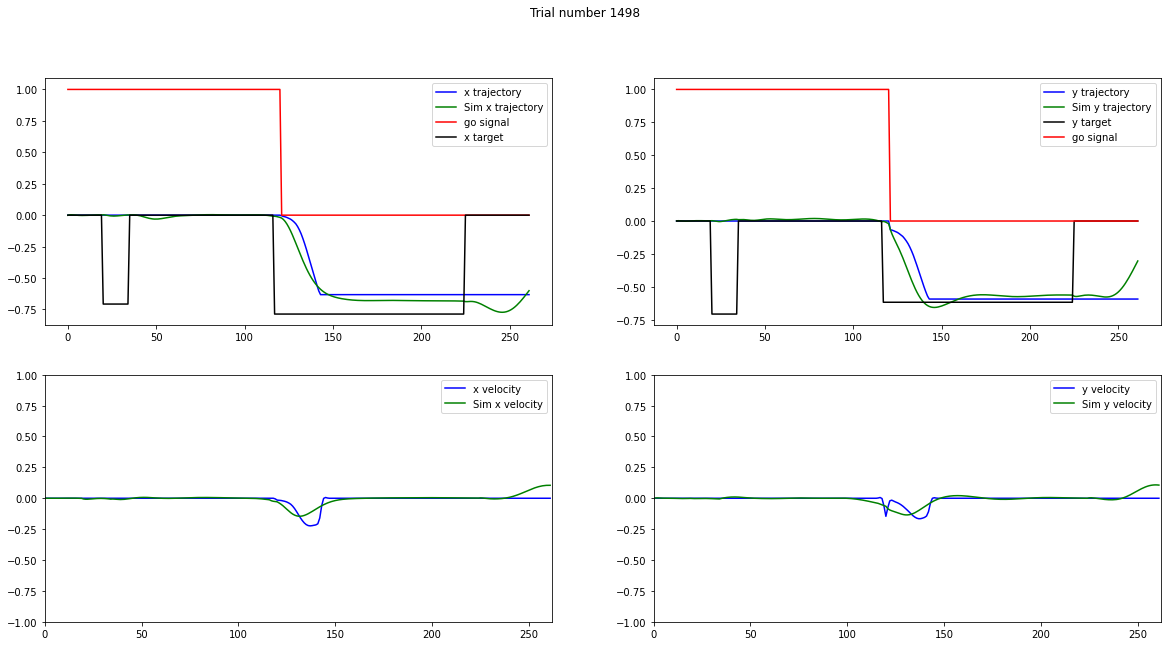

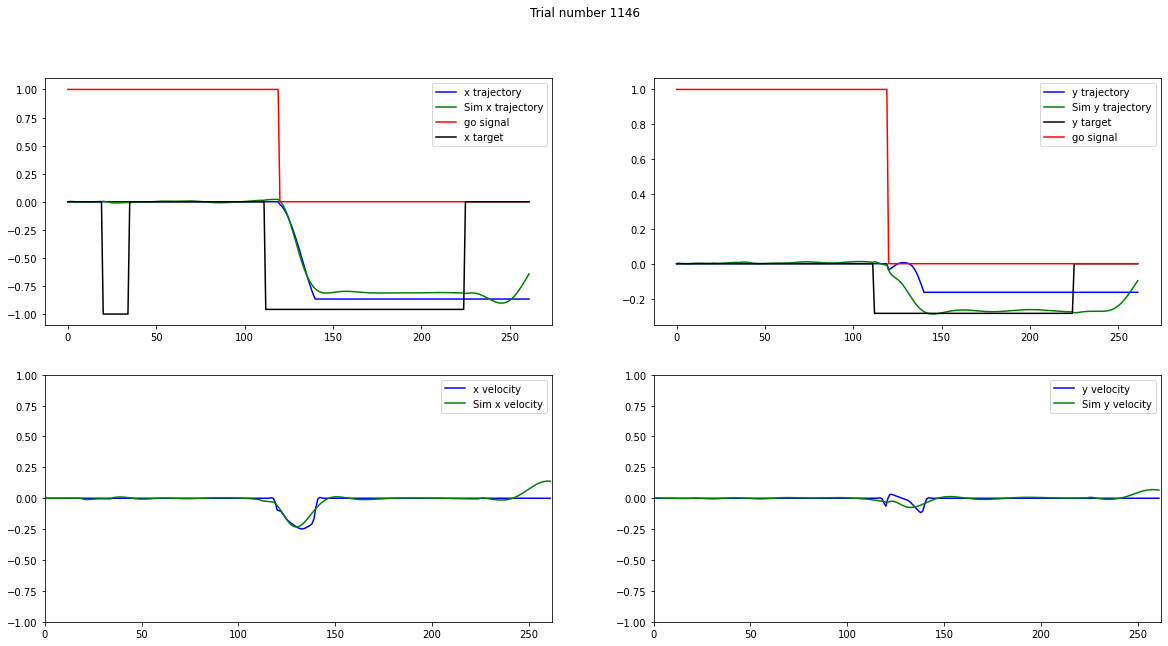

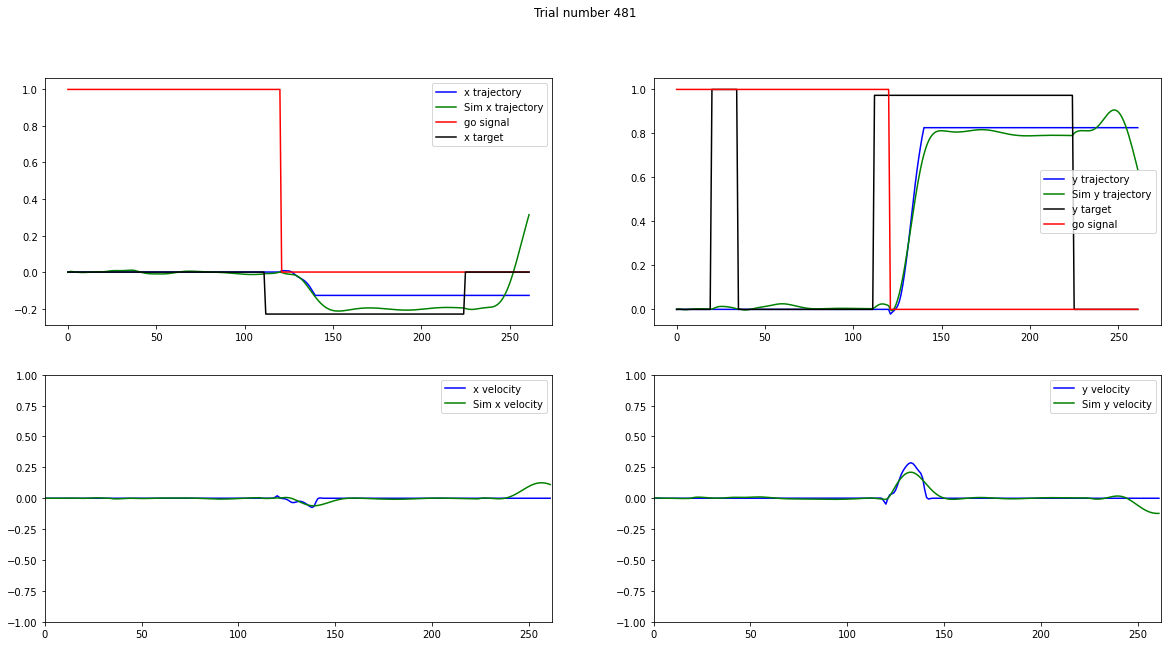

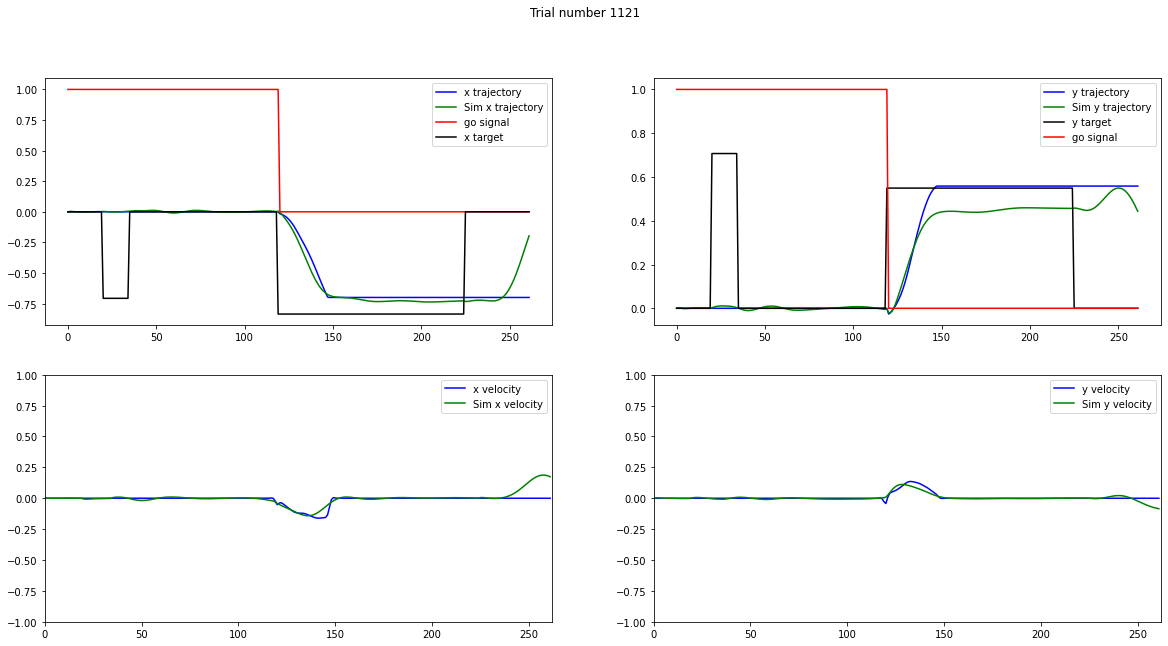

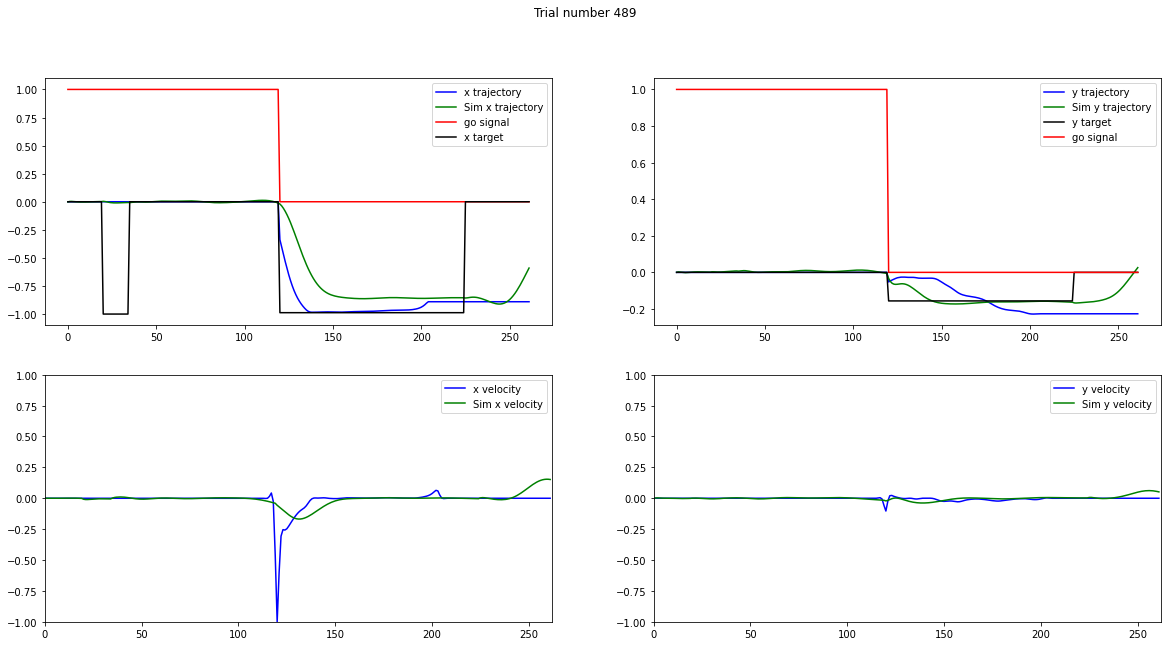

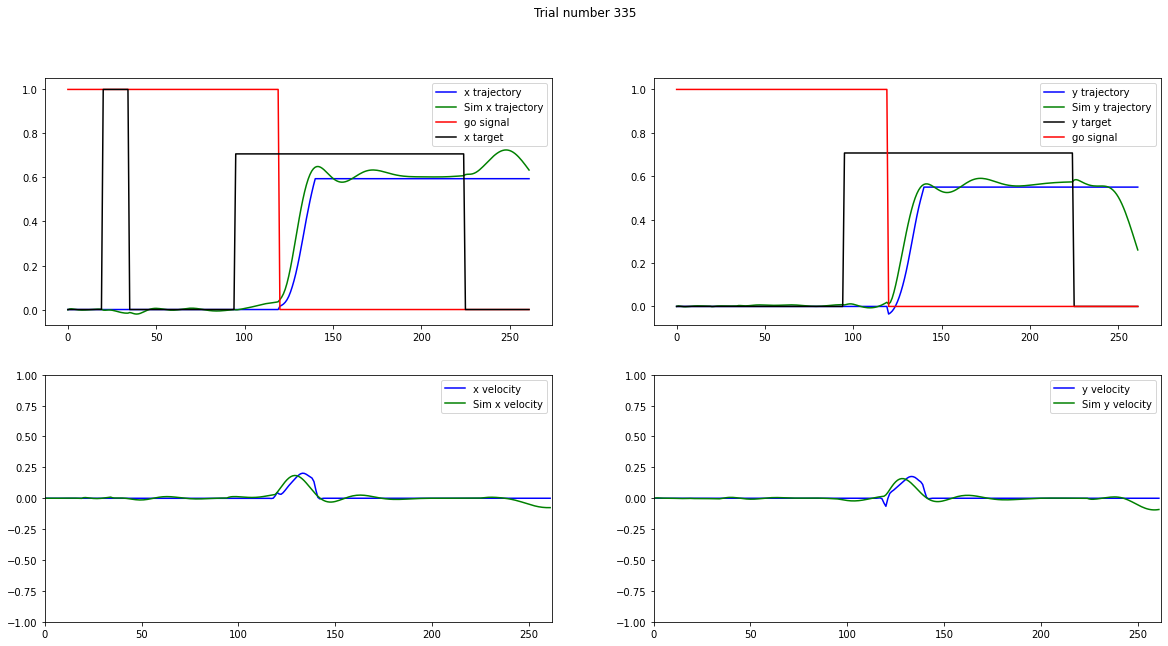

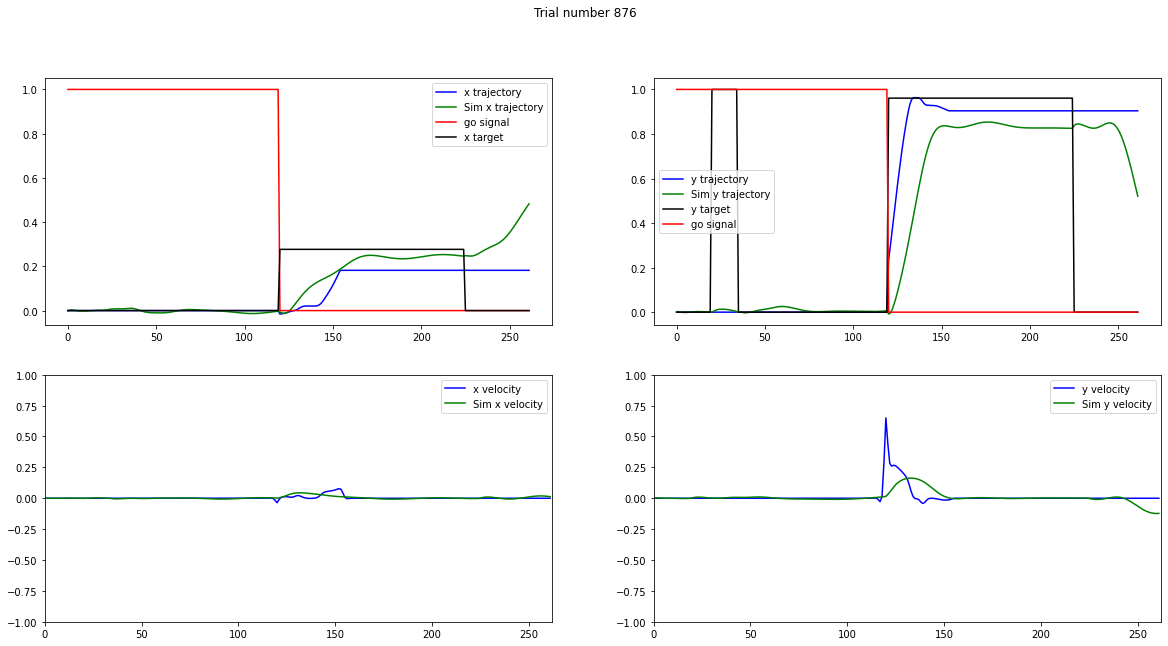

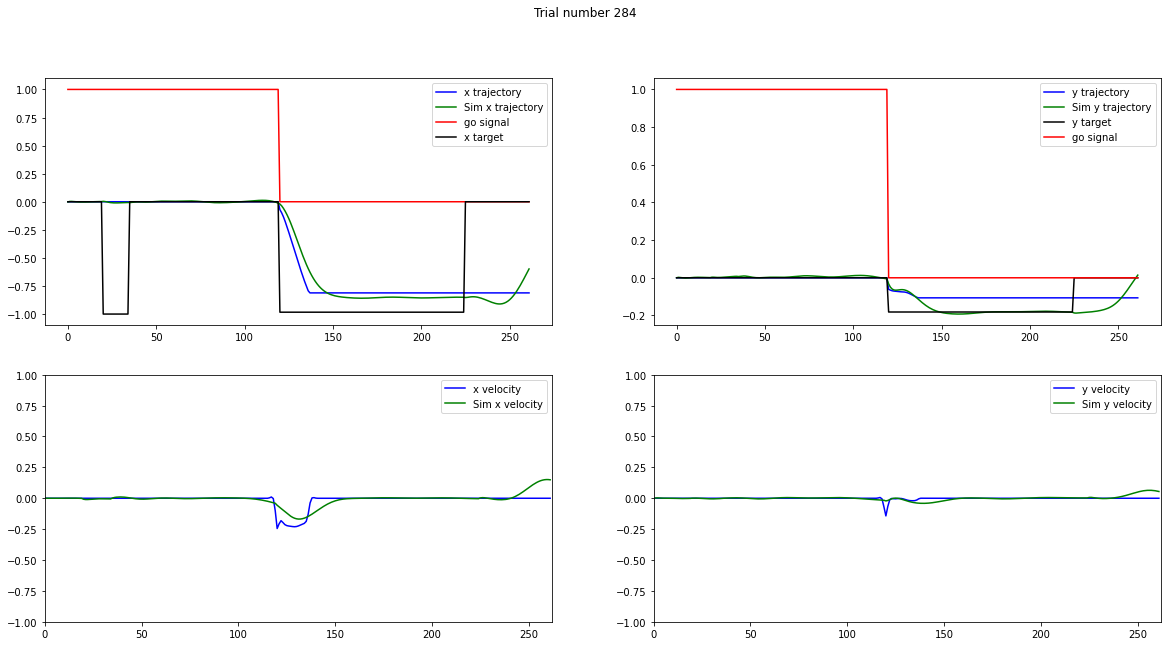

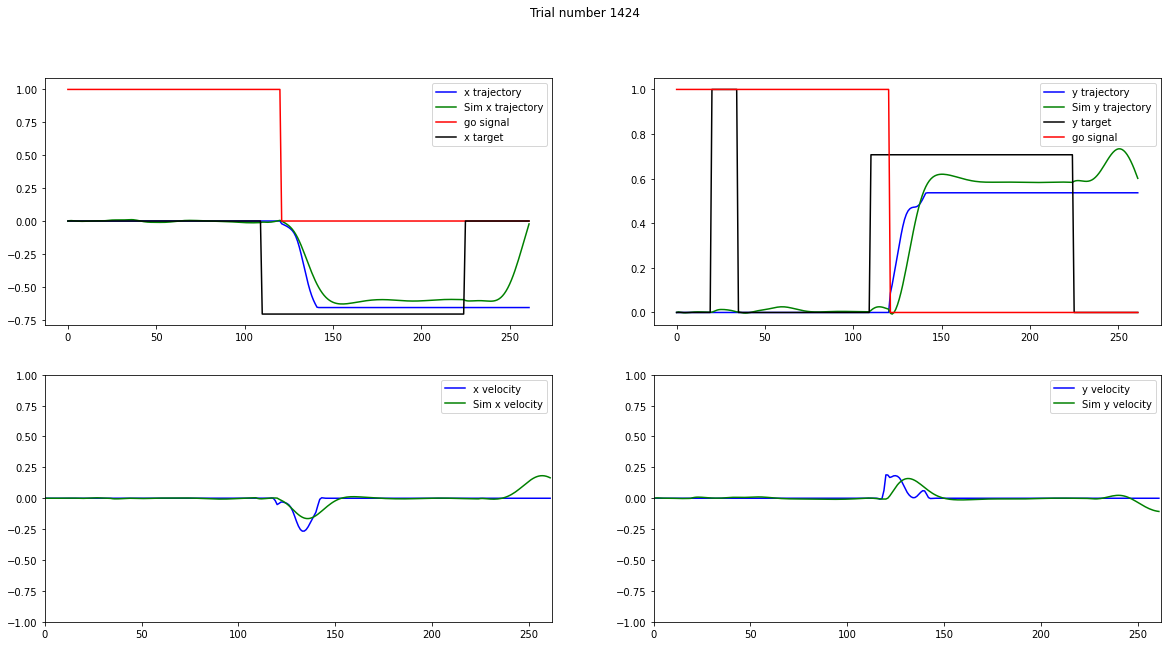

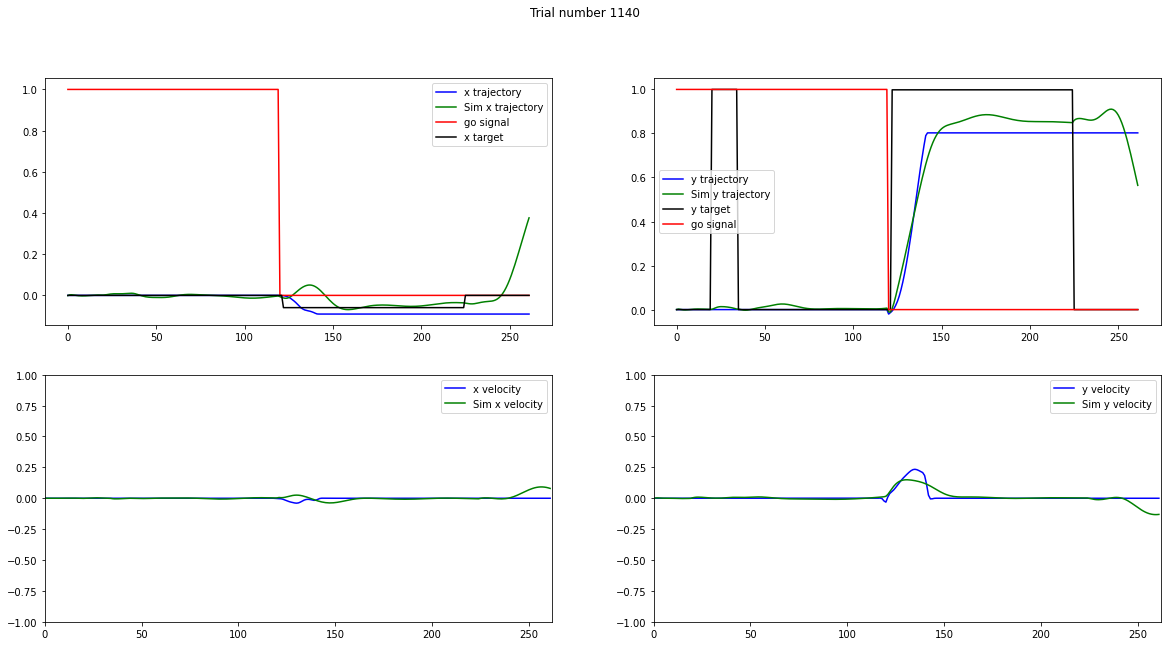

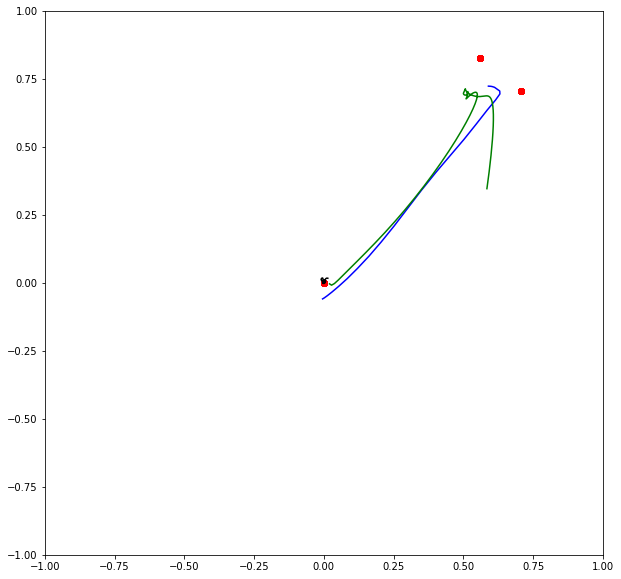

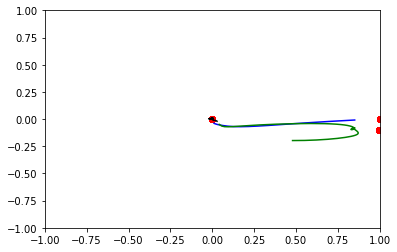

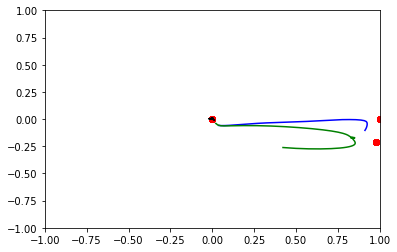

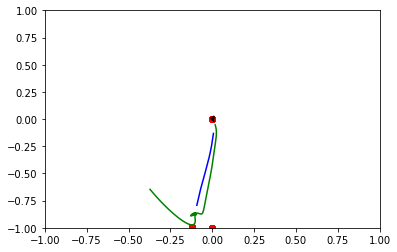

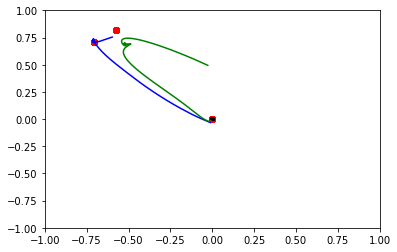

In [63]:
mn.run_pert_trials()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


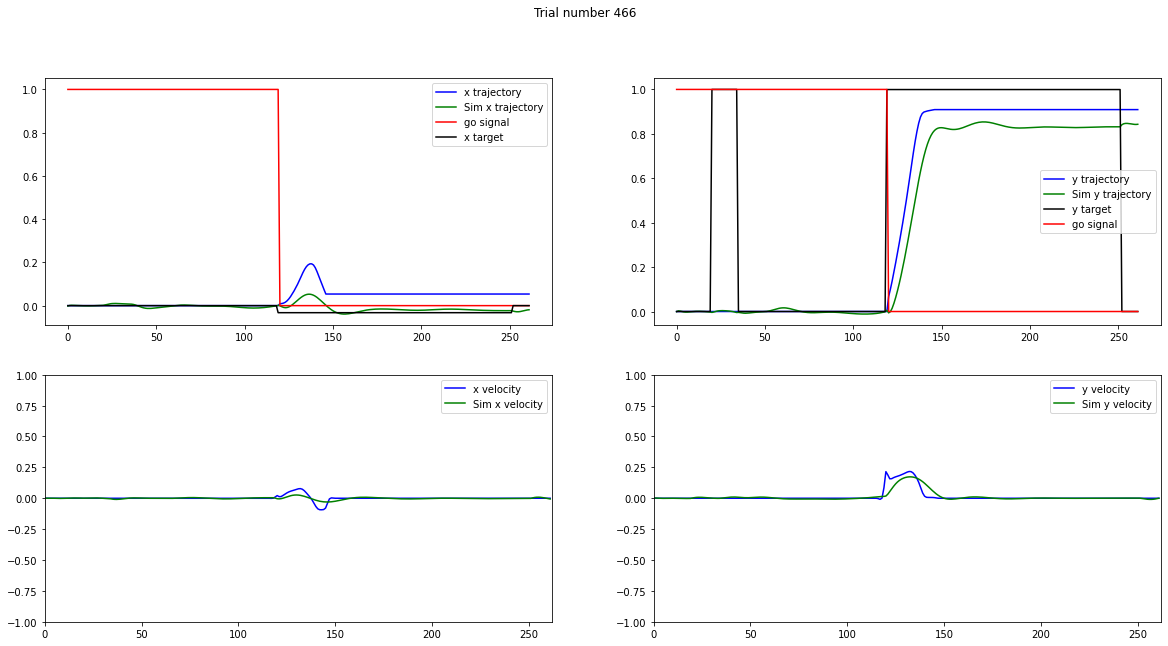

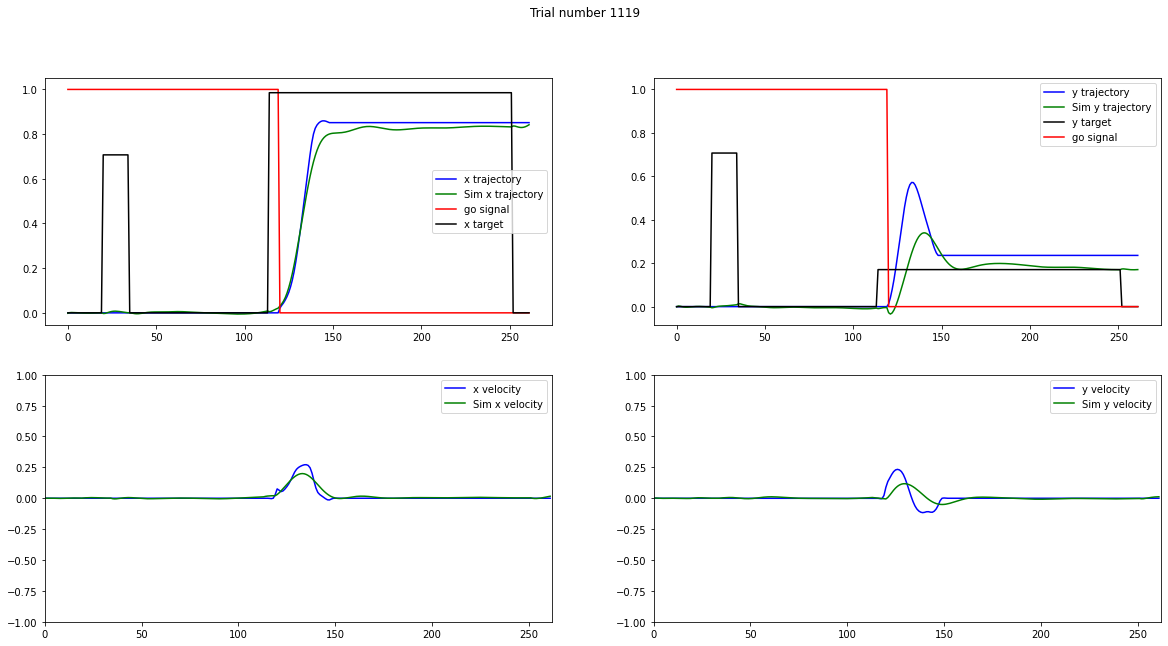

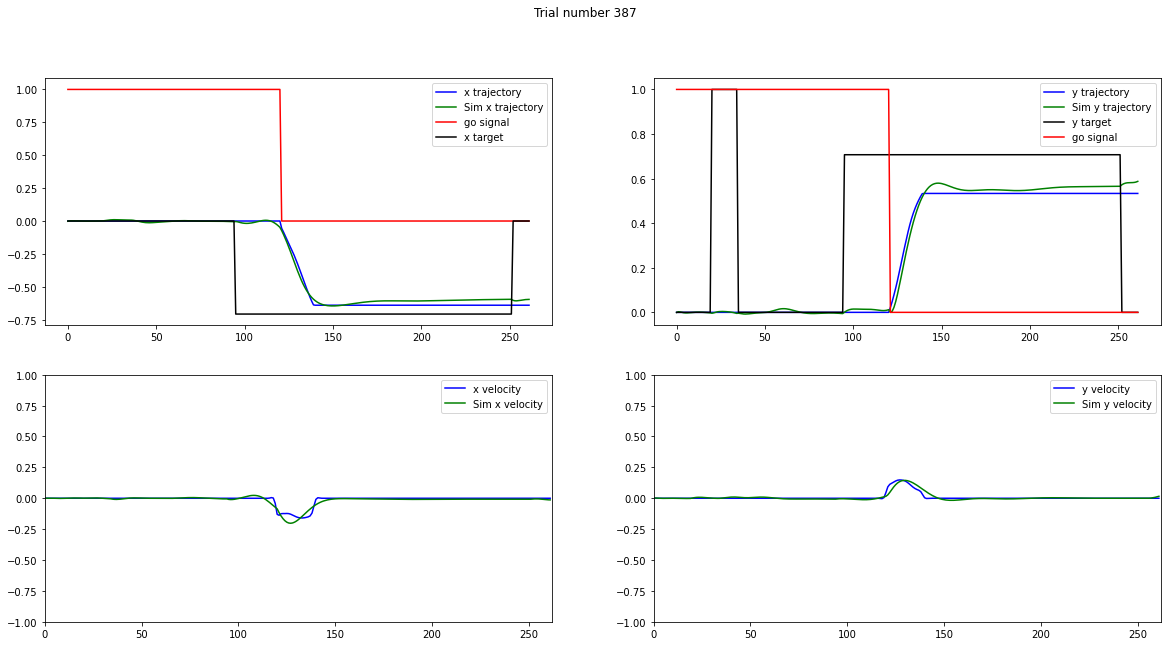

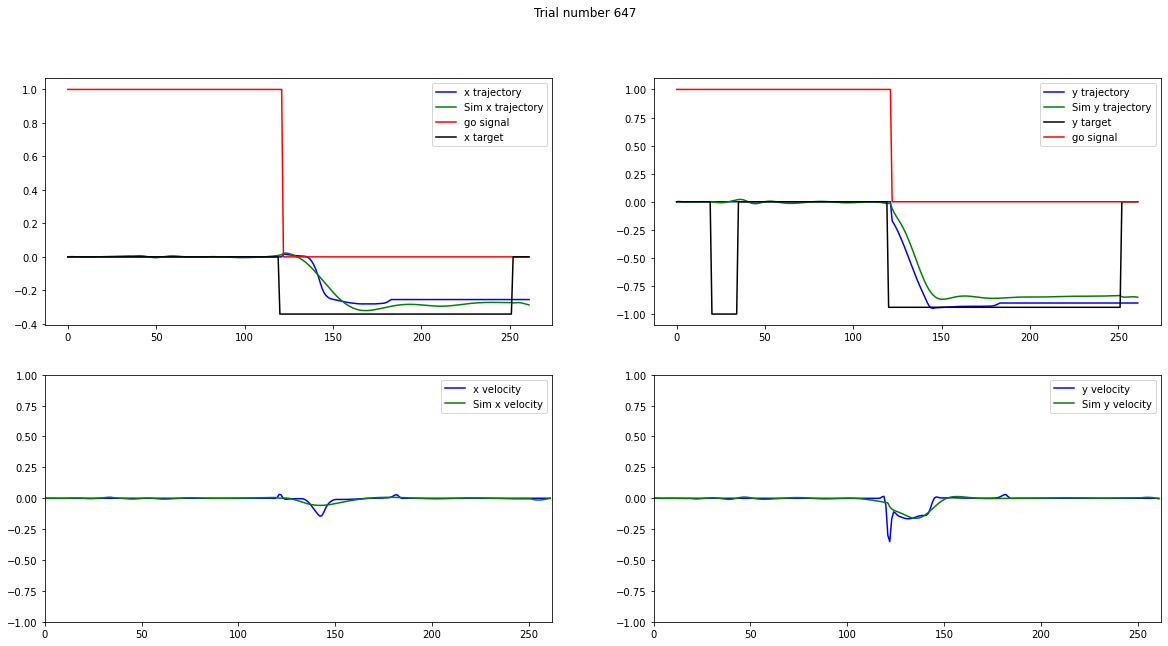

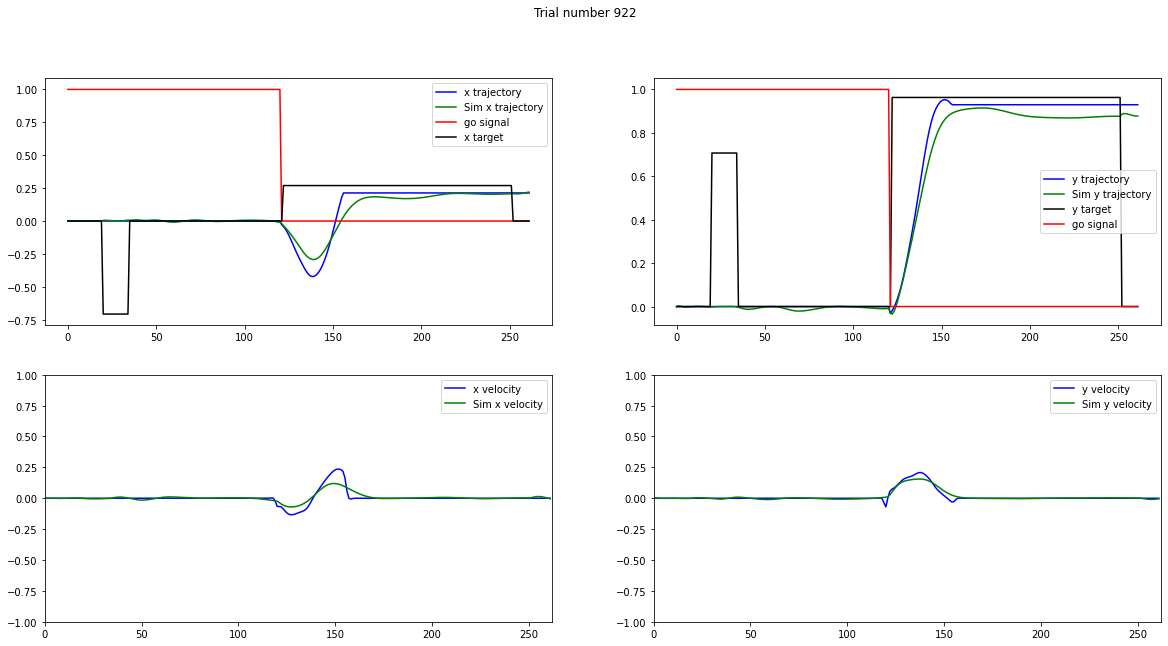

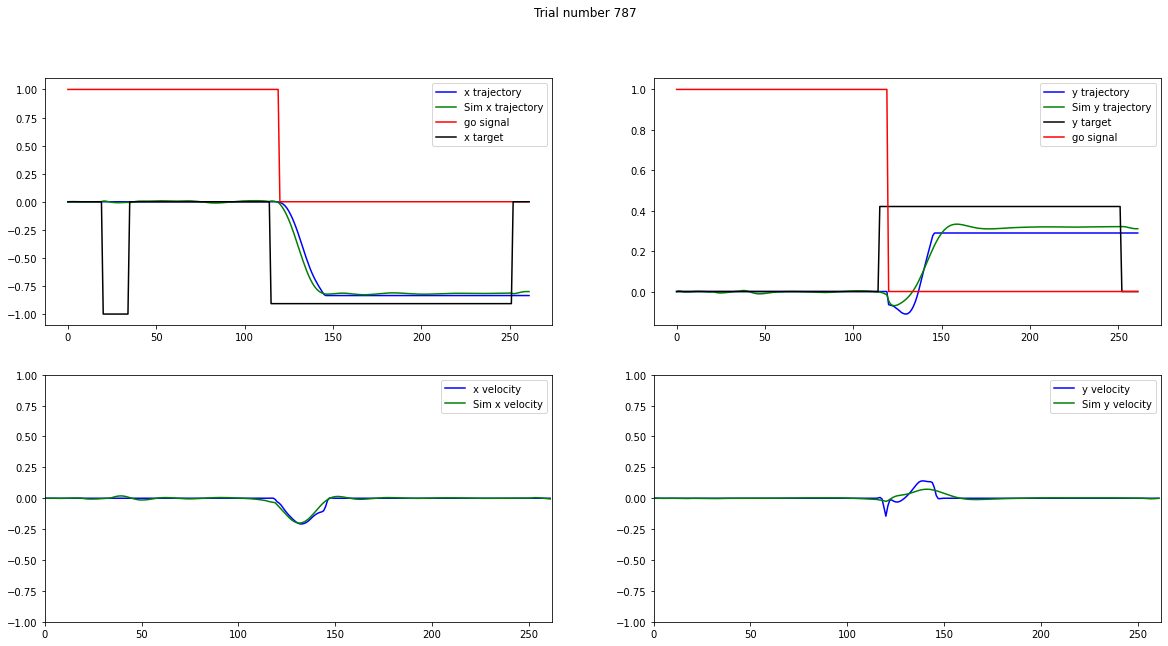

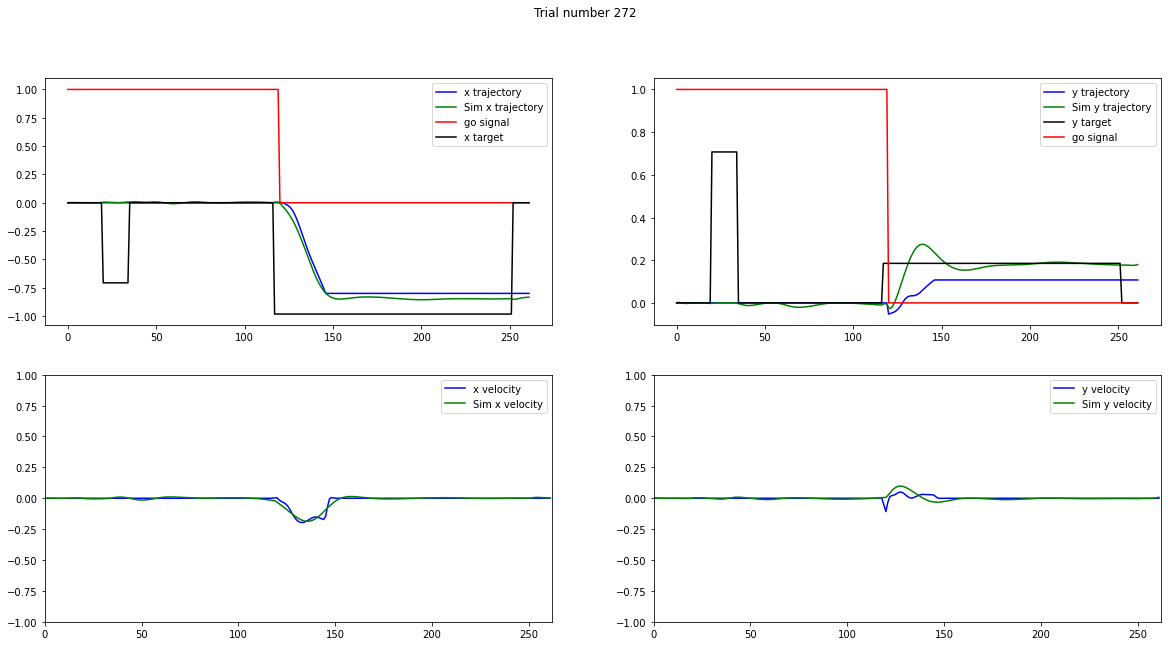

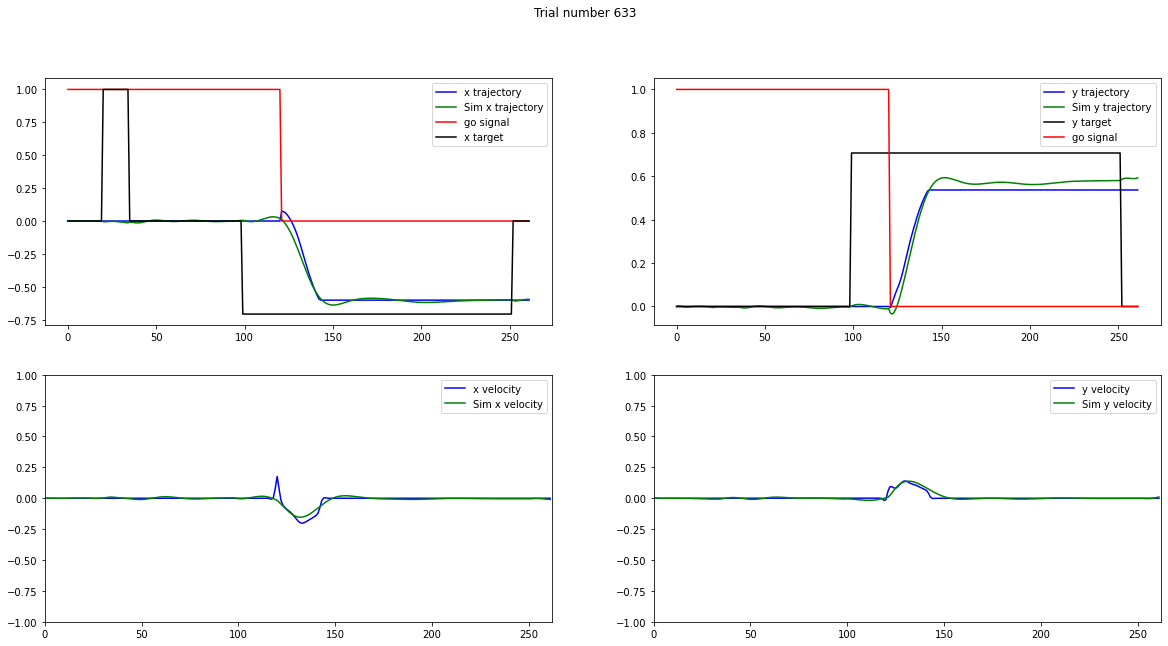

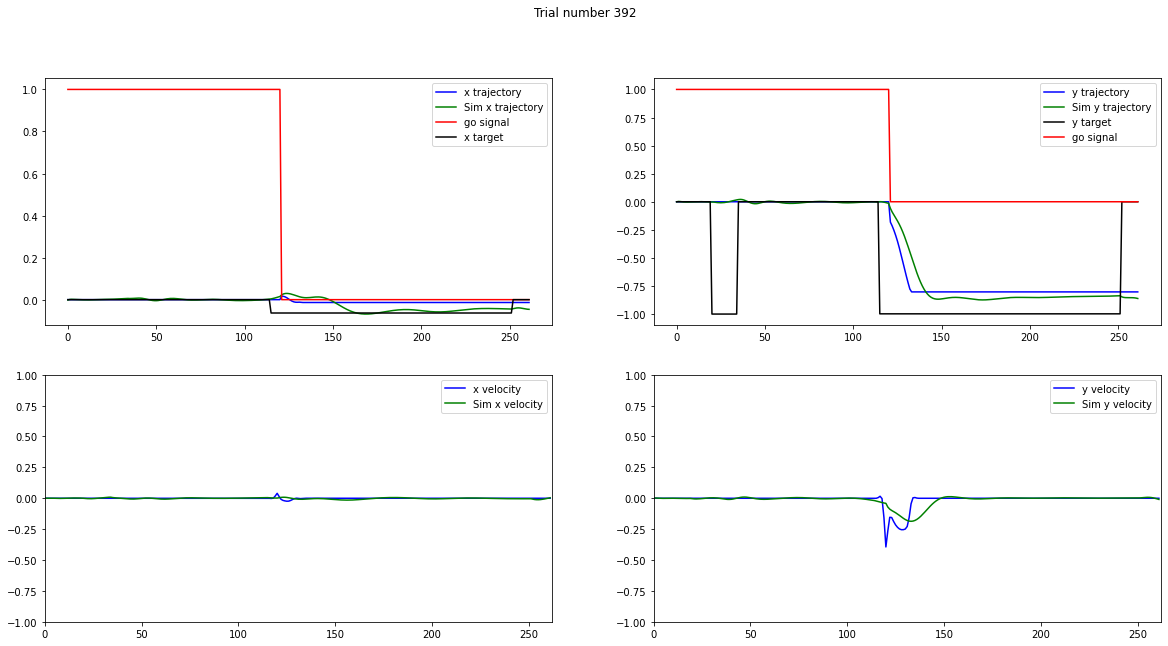

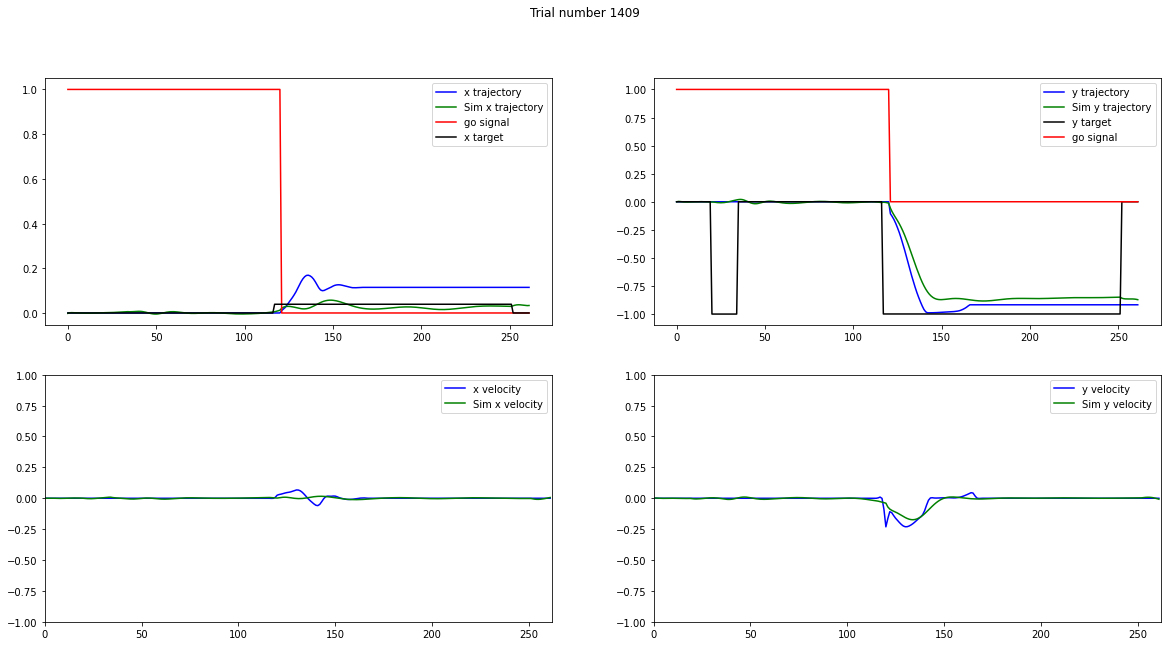

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


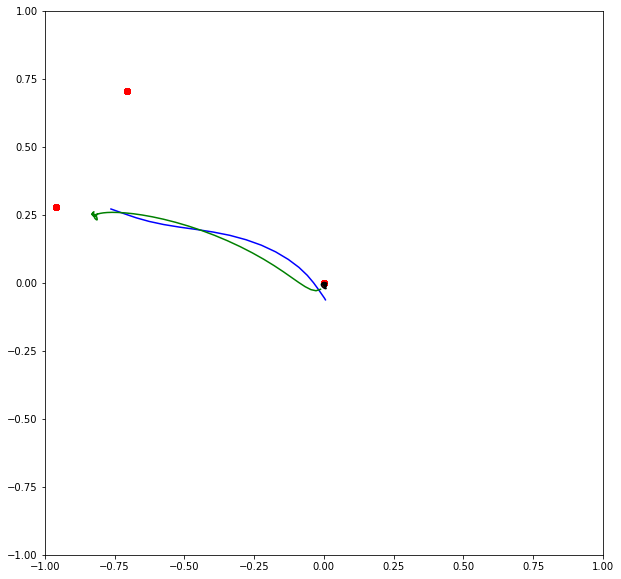

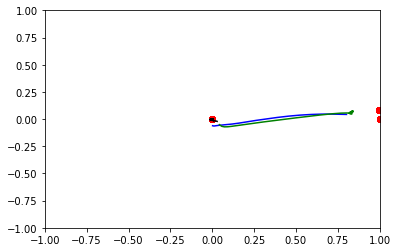

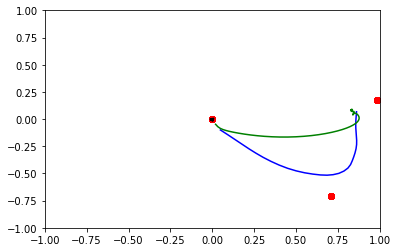

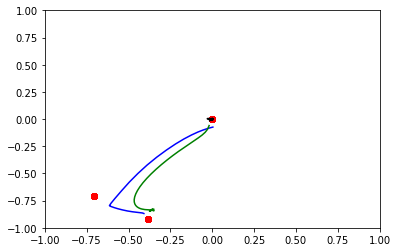

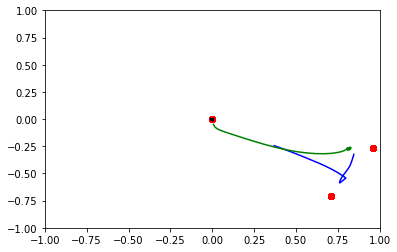

In [12]:
hn.run_pert_trials()

In [ ]:
time_increment=10
offset_angle=135
delay_range=[10,460]
test_output_135, test_trials_135, test_fr_135, delays_135= run_and_construct_test_trials_of_var_delays(time_increment,offset_angle, delay_range)
plot_trials_w_var_delays(test_output_135, test_trials_135, delays_135)

In [ ]:
test_out_135,ind=np.unique(test_output_135,axis=1,return_index=True)
test_out_135=test_out_135[:,np.argsort(ind)]

test_input_135,ind=np.unique(test_trials_135,axis=1,return_index=True)
test_input_135=test_input_135[:,np.argsort(ind)]

angles_135=[]
v_135=[]
i=4
point1_time=123
point2_time=126
for i in range(test_out_135.shape[1]):
  p1_rv= [test_input_135[0,i,0,0],test_input_135[0,i,0,1]]
  p2_rv= [test_input_135[0,i,30,0],test_input_135[0,i,30,1]]
  rv= [(p2_rv[0]-p1_rv[0]),(p2_rv[1]-p1_rv[1])]
  v_135=[]
  for j in range(test_out_135.shape[0]):
    p1= [test_out_135[j,i,point1_time,0],test_out_135[j,i,point1_time,1]]
    p2= [test_out_135[j,i,point2_time,0],test_out_135[j,i,point2_time,1]]
    A=[(p2[0]-p1[0]),(p2[1]-p1[1])]
    dot_product= np.inner(rv,A)
    mag = LA.norm(rv)*LA.norm(A)
    rad= np.arccos(np.clip((dot_product/mag),-1.0,1.0))
    deg= np.rad2deg(rad)
    v_135.append(deg)
  plt.scatter(delays_135,v_135)
  angles_135.append(v_135)
  

In [ ]:
transformed_test_fr, non_pert_pca_fr = perform_pca(test_fr_135,test_trials_135, limit=1200)
plot_first_2pcs(transformed_test_fr, non_pert_pca_fr, delays_135, limit=1200)

In [ ]:
time_increment=10
offset_angle=45
delay_range=[10,460]
test_output, test_trials, test_fr, delays= run_and_construct_test_trials_of_var_delays(time_increment,offset_angle, delay_range)
plot_trials_w_var_delays(test_output, test_trials, delays)

In [ ]:
test_out,ind=np.unique(test_output,axis=1,return_index=True)
test_out=test_out[:,np.argsort(ind)]

test_input,ind=np.unique(test_trials,axis=1,return_index=True)
test_input=test_input[:,np.argsort(ind)]
angles_45=[]

i=0
point1_time=123
point2_time=126

for i in range(test_out.shape[1]):
  p1_rv= [test_input[0,i,0,0],test_input[0,i,0,1]]
  p2_rv= [test_input[0,i,30,0],test_input[0,i,30,1]]
  rv= [(p2_rv[0]-p1_rv[0]),(p2_rv[1]-p1_rv[1])]
  v_45=[]
  for j in range(test_out.shape[0]):
    p1= [test_out[j,i,point1_time,0],test_out[j,i,point1_time,1]]
    p2= [test_out[j,i,point2_time,0],test_out[j,i,point2_time,1]]
    A=[(p2[0]-p1[0]),(p2[1]-p1[1])]
    dot_product= np.inner(rv,A)
    mag = LA.norm(rv)*LA.norm(A)
    rad= np.arccos(np.clip((dot_product/mag),-1.0,1.0))
    deg= np.rad2deg(rad)
    v_45.append(deg)
  plt.scatter(delays,v_45)
  angles_45.append(v_45)
  


In [ ]:
angles_45=np.array(angles_45)
angles_135=np.array(angles_135)
mean_angles_45=np.mean(angles_45,axis=0)
mean_angles_135=np.mean(angles_135,axis=0)

Norm_v_135= mean_angles_135/np.max(mean_angles_135)
Norm_v_45= mean_angles_45/np.max(mean_angles_45)
plt.figure(figsize=(10,10))
plt.scatter(delays,Norm_v_135,c='r', label='135 pert')
plt.scatter(delays,Norm_v_45,c='b', label= '45 pert')
plt.legend()
plt.title('mean heading angle Vs delay')
plt.xlabel('delays in ms')
plt.ylabel('normalized mean heading angle')

In [ ]:
Norm_v_135= v_135/np.max(v_135)
Norm_v_45= v_45/np.max(v_45)
plt.figure(figsize=(10,10))
plt.scatter(delays,Norm_v_135,c='r', label='135 pert')
plt.scatter(delays,Norm_v_45,c='b', label= '45 pert')
plt.legend()
plt.title('heading angle Vs delay for one condition only')
plt.xlabel('delays in ms')
plt.ylabel('normalized heading angle')

In [ ]:
transformed_test_fr, non_pert_pca_fr = perform_pca(test_fr,test_trials, limit=1200)
plot_first_2pcs(transformed_test_fr, non_pert_pca_fr, delays, limit=1200)

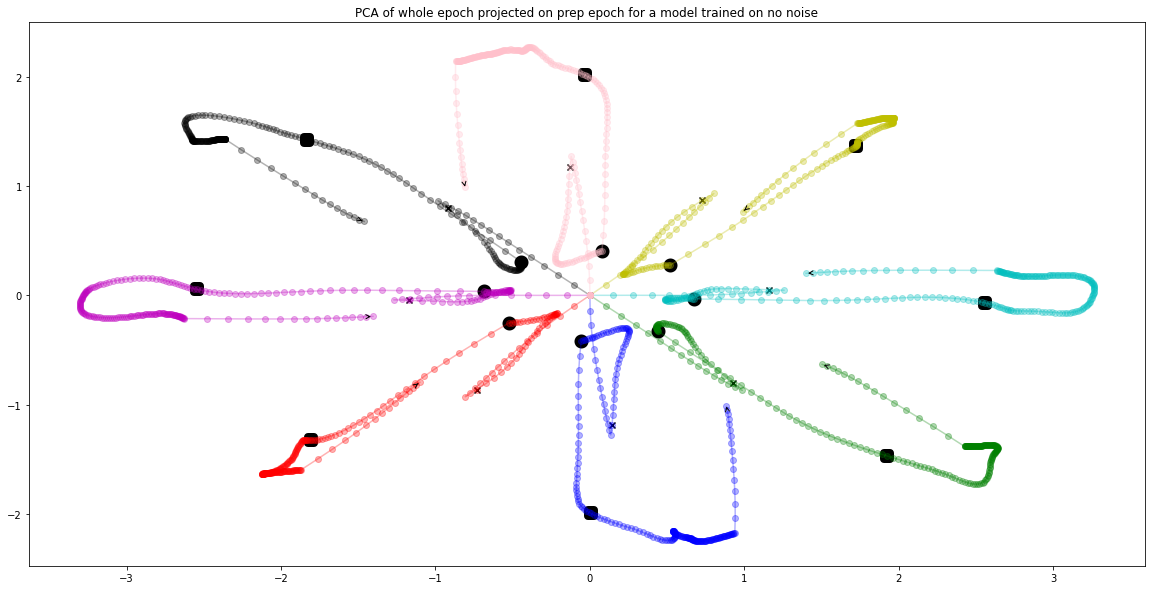

black circle denotes pre-target off 
black cross denotes target on 
black square denotes end of prepratory epoch


In [205]:
######plotting whole epoch on prep manifold
limit=int(1100/dt)
lower_limit=int(810/dt)

pca_ready_prep_epoch = prep_data_for_pca(od.avg_non_pert_firing_rates[:,lower_limit:limit,:])
pca_ready_fr=prep_data_for_pca(od.avg_non_pert_firing_rates[:,:limit,:])
full_pca_ready_fr=prep_data_for_pca(od.avg_non_pert_firing_rates[:,:,:])

pca = PCA(3)
prep_epoch= pca.fit(pca_ready_prep_epoch)
pc_fr=pca.transform(pca_ready_fr)
full_pc_fr=pca.transform(full_pca_ready_fr)
c=['b','g','r','c','m','y','k','pink']


plt.figure(figsize=(20,10))
j=0
for i in range(limit,pc_fr.shape[0]+limit,limit):
  plt.scatter(pc_fr[i-1,0],pc_fr[i-1,1],c='k',marker='s',linewidths=8)
  plt.scatter(pc_fr[j+35,0],pc_fr[j+35,1],c='k',marker='x',linewidths=8)
  plt.scatter(pc_fr[j+80,0],pc_fr[j+80,1],c='k',marker='o',linewidths=8)
  j=i
j=0
for i in range(od.avg_non_pert_firing_rates.shape[1],full_pc_fr.shape[0]+od.avg_non_pert_firing_rates.shape[1],od.avg_non_pert_firing_rates.shape[1]):
  plt.plot(full_pc_fr[j:i,0],full_pc_fr[j:i,1],c=c[int(i/od.avg_non_pert_firing_rates.shape[1])-1],marker='o',alpha=0.3)
  plt.annotate("", xy=(full_pc_fr[i-1,0],full_pc_fr[i-1,1]), xytext=(full_pc_fr[i-2,0],full_pc_fr[i-2,1]),arrowprops=dict(arrowstyle="->"))
  j=i
  plt.title('PCA of whole epoch projected on prep epoch for a model trained on no noise')
plt.show()
print('black circle denotes pre-target off \nblack cross denotes target on \nblack square denotes end of prepratory epoch')

In [102]:
#save model weights
wd=os.getcwd()
wd=wd+'/weights_model_trained_on_hn'
basicModel.save(wd)

In [35]:
od.save_pcs()

In [ ]:
# ---------------------- Teardown the model -------------------------
basicModel.destruct()